In [1]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer.git
!curl -O https://raw.githubusercontent.com/AarohiSingla/Image-Classification-Using-Vision-transformer/main/helper_functions.py

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29
Receiving objects: 100% (43/43), 862.14 KiB | 20.53 MiB/s, done.
Resolving deltas: 100% (15/15), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6412  100  6412    0     0  24095      0 --:--:-- --:--:-- --:--:-- 24105


In [2]:
import helper_functions
from google.colab import drive

import matplotlib.pyplot as plt
from random import random
import torch
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import tensorflow as tf

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ViT/hurricane.zip"
datasetPath='hurricane'
os.listdir(datasetPath)

Streaming output truncated to the last 5000 lines.
  inflating: hurricane/train/damage/-95.638343_29.841283.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.638343_29.841283.jpeg  
  inflating: hurricane/train/damage/-95.08795699999999_29.846401.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.08795699999999_29.846401.jpeg  
  inflating: hurricane/train/damage/-95.15535899999999_30.021469.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.15535899999999_30.021469.jpeg  
  inflating: hurricane/train/damage/-95.53323_29.747687.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.53323_29.747687.jpeg  
  inflating: hurricane/train/damage/-95.096357_29.807941999999997.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.096357_29.807941999999997.jpeg  
  inflating: hurricane/train/damage/-95.63247199999999_29.844943.jpeg  
  inflating: __MACOSX/hurricane/train/damage/._-95.63247199999999_29.844943.jpeg  
  inflating: hurricane/train/damage/-93.793368_30.0

['.DS_Store', 'valid', 'test', 'train']

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = '/content/hurricane/train'
test_dir = '/content/hurricane/test'
valid_dir = '/content/hurricane/valid'

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    valid_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  valid_data = datasets.ImageFolder(valid_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
  valid_dataloader = DataLoader(
      valid_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, valid_dataloader, class_names

In [5]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, valid_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    valid_dir=valid_dir,  # Pass the validation directory
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, valid_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ba39f459210>,
 ['damage', 'no_damage'])

torch.Size([3, 224, 224]) tensor(0)


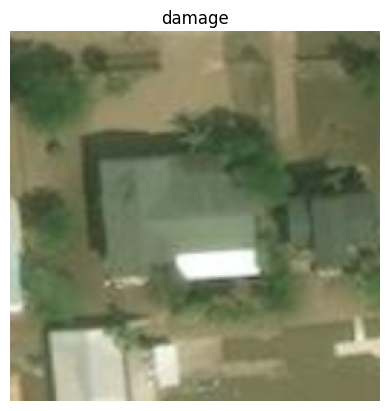

In [7]:
# visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [8]:
# 1. Create a class which subclasses nn.Module
#number of patches = (224/16) * (224/16) = 14*14 = 196 patches
class PatchEmbedding(nn.Module):
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [9]:
# test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [10]:
# View the patch embedding and patch embedding shape


print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.3856,  0.1256, -0.0560,  ...,  0.3420, -0.2528,  0.0869],
         [-0.4690,  0.1287, -0.0327,  ...,  0.3281, -0.3058,  0.0546],
         [-0.4535,  0.1228, -0.0910,  ...,  0.3317, -0.2828,  0.1436],
         ...,
         [-0.4756,  0.1173, -0.1409,  ...,  0.3461, -0.2261,  0.1697],
         [-0.4763,  0.1096, -0.1402,  ...,  0.3444, -0.2241,  0.1744],
         [-0.4745,  0.1148, -0.1405,  ...,  0.3440, -0.2255,  0.1727]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [11]:
# Now add the the learnable class embedding and position embeddings
# From start to positional encoding: All in 1 cell

set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3856,  0.1256, -0.0560,  ...,  0.3420, -0.2528,  0.0869],
         [-0.4690,  0.1287, -0.0327,  ...,  0.3281, -0.3058,  0.0546],
         ...,
         [-0.4756,  0.1173, -0.1409,  ...,  0.3461, -0.2261,  0.1697],
         [-0.4763,  0.1096, -0.1402,  ...,  0.3444, -0.2241,  0.1744],
         [-0.4745,  0.1148, -0.1405,  ...,  0.3440, -0.2255,  0.1727]]],
       grad_fn=<CatBackward0>)


# Creating Transformer Encoder

In [12]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12,
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [13]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [14]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):

        x =  self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x


In [15]:
!pip install torchinfo

In [16]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Creating Vision Transformer

In [17]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)


        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):

        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

## Training

In [18]:
vit = ViT(num_classes=len(class_names))

In [19]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning

from going_modular.going_modular import engine


Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 4036 (delta 1067), reused 1080 (delta 995), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.50 MiB | 27.18 MiB/s, done.
Resolving deltas: 100% (2360/2360), done.
Updating files: 100% (248/248), done.


In [20]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=valid_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7559 | train_acc: 0.5061 | test_loss: 0.6950 | test_acc: 0.4960
Epoch: 2 | train_loss: 0.6934 | train_acc: 0.5061 | test_loss: 0.6934 | test_acc: 0.4960
Epoch: 3 | train_loss: nan | train_acc: 0.5156 | test_loss: nan | test_acc: 0.4960
Epoch: 4 | train_loss: nan | train_acc: 0.5153 | test_loss: nan | test_acc: 0.4960
Epoch: 5 | train_loss: nan | train_acc: 0.5153 | test_loss: nan | test_acc: 0.4960
Epoch: 6 | train_loss: nan | train_acc: 0.5146 | test_loss: nan | test_acc: 0.4960
Epoch: 7 | train_loss: nan | train_acc: 0.5158 | test_loss: nan | test_acc: 0.4960
Epoch: 8 | train_loss: nan | train_acc: 0.5151 | test_loss: nan | test_acc: 0.4960
Epoch: 9 | train_loss: nan | train_acc: 0.5151 | test_loss: nan | test_acc: 0.4960
Epoch: 10 | train_loss: nan | train_acc: 0.5153 | test_loss: nan | test_acc: 0.4960


## Performance Metrics

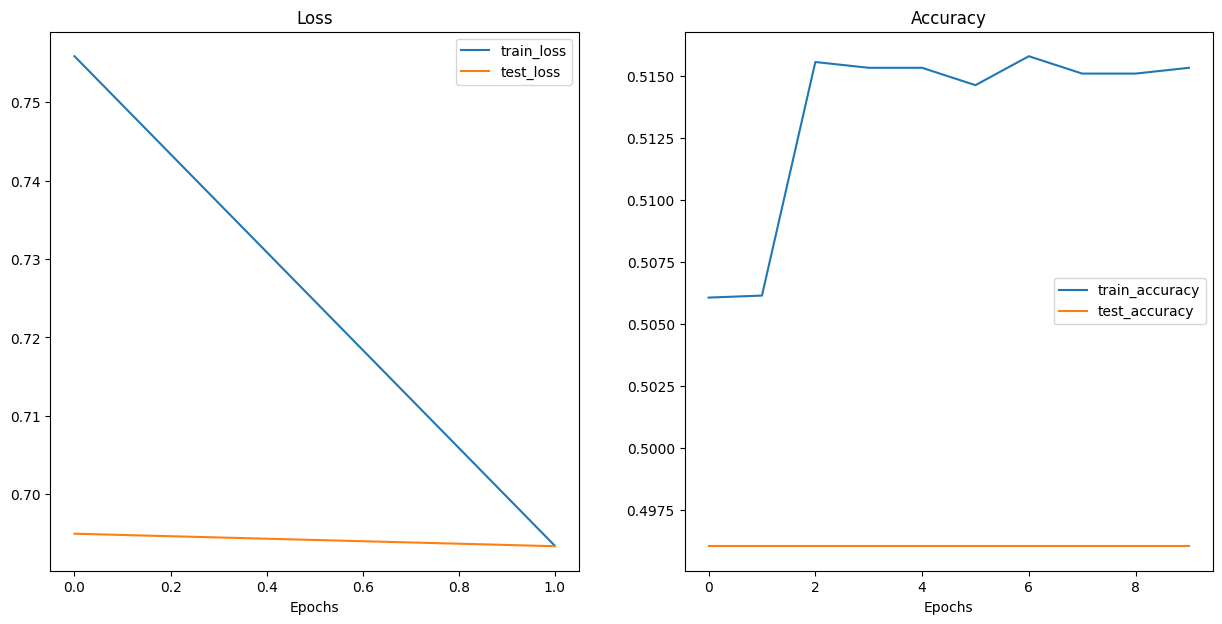

In [21]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

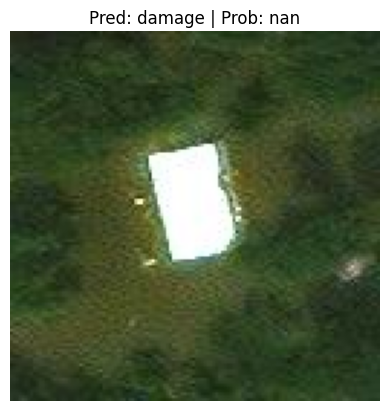

In [22]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/hurricane/test/damage/-93.547871_30.900207.jpeg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

## Using Pretrained model


In [24]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['damaged','no damage']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 181MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [25]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [26]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [27]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    valid_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  valid_data = datasets.ImageFolder(valid_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
  valid_dataloader = DataLoader(
      valid_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, valid_dataloader, class_names

In [28]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, valid_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                      valid_dir=valid_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [30]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=valid_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1069 | train_acc: 0.9611 | test_loss: 0.1094 | test_acc: 0.9568
Epoch: 2 | train_loss: 0.0917 | train_acc: 0.9661 | test_loss: 0.0999 | test_acc: 0.9623
Epoch: 3 | train_loss: 0.0839 | train_acc: 0.9689 | test_loss: 0.0987 | test_acc: 0.9593
Epoch: 4 | train_loss: 0.0785 | train_acc: 0.9719 | test_loss: 0.0933 | test_acc: 0.9613
Epoch: 5 | train_loss: 0.0736 | train_acc: 0.9730 | test_loss: 0.0897 | test_acc: 0.9648
Epoch: 6 | train_loss: 0.0711 | train_acc: 0.9716 | test_loss: 0.0910 | test_acc: 0.9608
Epoch: 7 | train_loss: 0.0673 | train_acc: 0.9758 | test_loss: 0.0901 | test_acc: 0.9643
Epoch: 8 | train_loss: 0.0649 | train_acc: 0.9764 | test_loss: 0.0888 | test_acc: 0.9653
Epoch: 9 | train_loss: 0.0623 | train_acc: 0.9773 | test_loss: 0.0905 | test_acc: 0.9638
Epoch: 10 | train_loss: 0.0606 | train_acc: 0.9774 | test_loss: 0.0928 | test_acc: 0.9643


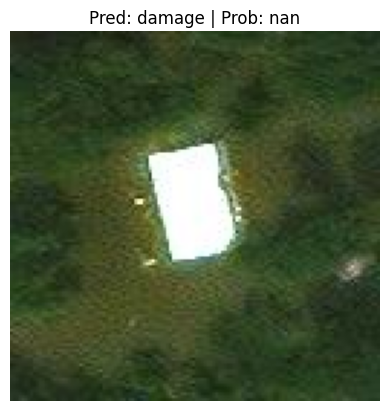

In [31]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/hurricane/test/damage/-93.547871_30.900207.jpeg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

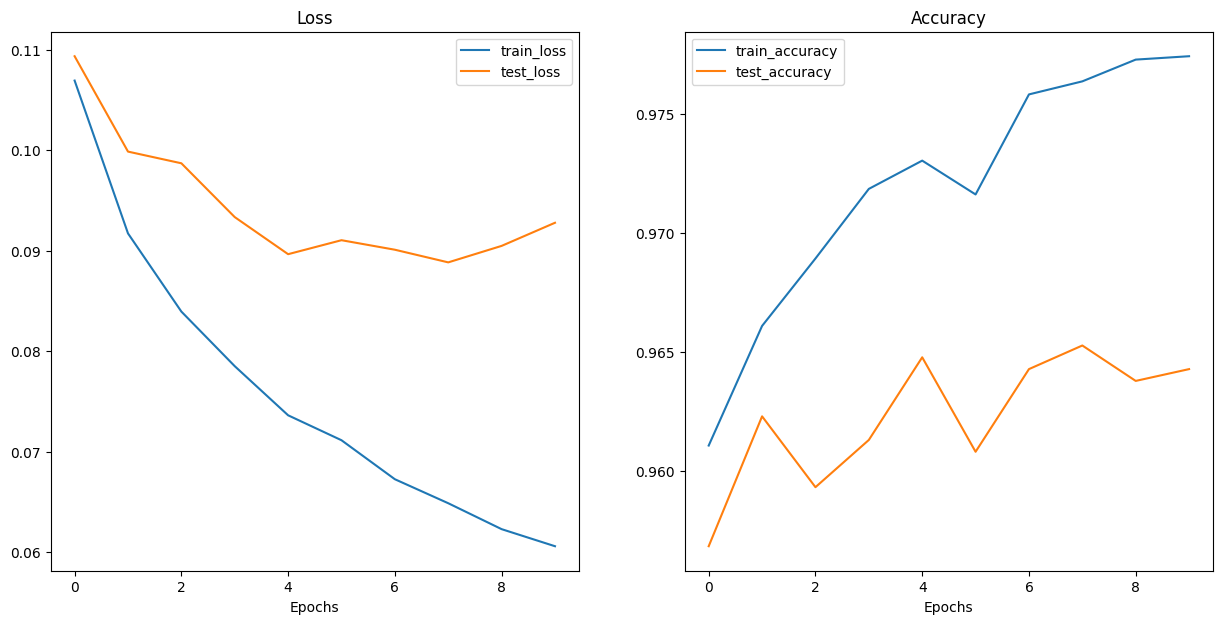

In [32]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
# Set the model to evaluation mode
vit.eval()

eval_labels = np.array([])
eval_predictions = np.array([])
with torch.no_grad():
    for images, labels in test_dataloader_pretrained:
        images = images.to(device)
        labels = labels.to(device)

        outputs = pretrained_vit(images)

        probs = torch.nn.functional.softmax(outputs, dim=1)

        _, preds = torch.max(probs, 1)

        eval_predictions = np.append(eval_predictions, preds.cpu().numpy())
        eval_labels = np.append(eval_labels, labels.cpu().numpy())

eval_predictions = eval_predictions.astype(int)
eval_labels = eval_labels.astype(int)

print("eval_labels      : ", eval_labels.shape)
print("eval_predictions : ", eval_predictions.shape)

eval_labels      :  (9000,)
eval_predictions :  (9000,)


In [47]:
test = engine.test_step(model=vit,
              dataloader=test_dataloader_pretrained,
              loss_fn=loss_fn,
              device=device)

In [62]:
test

(nan, 0.8865248226950354)

In [67]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(eval_labels, eval_predictions)
print("F1 Score:", f1)


F1 Score: 0.8333333333333334


In [68]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(eval_labels, eval_predictions)

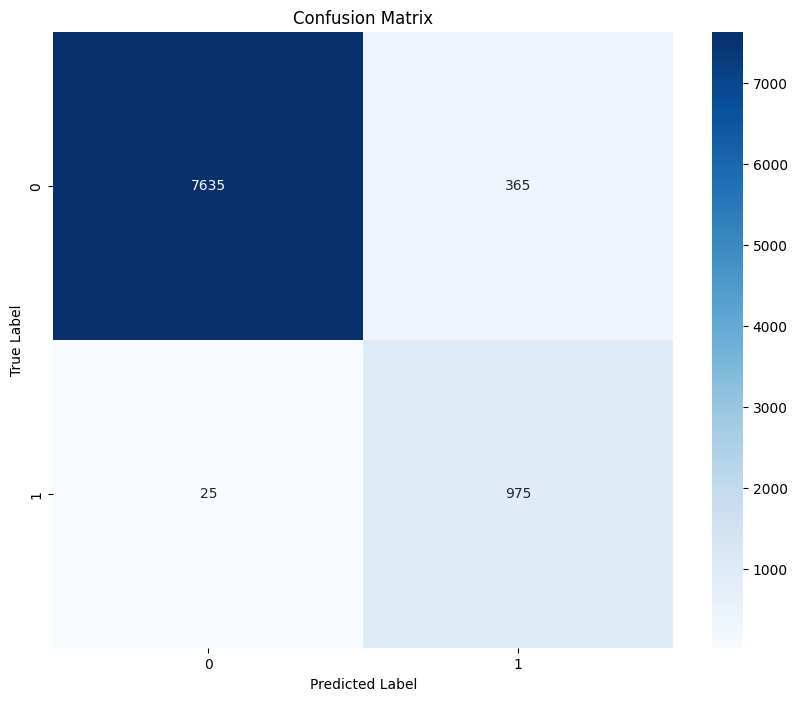

In [69]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

# ROC AUC Score
roc_auc = roc_auc_score(eval_labels, eval_predictions)

# Calculate ROC Curve
fpr, tpr, _ = roc_curve(eval_labels, eval_predictions)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(eval_labels, eval_predictions)

# PR AUC Score
pr_auc = auc(recall, precision)

# Print ROC and PR AUC scores
print("ROC AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)

ROC AUC Score: 0.9646874999999999
PR AUC Score: 0.8526948590381426


In [71]:
from sklearn.metrics import f1_score

TN = confusion_mtx[0,0]
FN = confusion_mtx[1,0]
TP = confusion_mtx[1,1]
FP = confusion_mtx[0,1]
F1 = f1_score(eval_labels, eval_predictions)

print('accuracy = {:.4f}'.format((TP+TN)/np.sum(confusion_mtx)))
print('positive recall = {:.4f}'.format(TP/(TP+FN)))
print('negative recall = {:.4f}'.format(TN/(TN+FP)))
print('positive precision = {:.4f}'.format(TP/(TP+FP)))
print('negative precision = {:.4f}'.format(TN/(TN+FN)))

accuracy = 0.9567
positive recall = 0.9750
negative recall = 0.9544
positive precision = 0.7276
negative precision = 0.9967
